In [97]:
import utils
import sys
if 'utils' in sys.modules:
    del sys.modules['utils']
import utils
import torch
from tqdm import tqdm
import random
import time
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nbformat
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

checkpoint_path = 'weights/checkpoint_32x32_deep.pth'
RESUME_TRAINING = False

PRINT_IMG = True
AUGMENT_DATASET = False
AUGMENT_FRACTION = 0.2
TRANSFORM_DATASET = False

COSINE_ANNEALING = True
STEPLR = False
REDUCE_ON_PLATEAU = False

OPTIMIZER='SGD'

### Hyperparameters ###
BATCH_SIZE = 128
LEARNING_RATE = 0.01
MOMENTUM = 0.9
EPOCHS = 30

WEIGHT_DECAY = 0

### Early Stopping ###
EARLY_STOPPING = True
ES_PATIENCE = 3

SEED = 0

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [2]:
train_dataset, train_dataset_raw = utils.create_train_dataset(TRANSFORM_DATASET, AUGMENT_DATASET, AUGMENT_FRACTION)
test_dataset, validation_dataset, test_dataset_raw = utils.create_test_dataset(validation_split=0.7)

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000
Dimensione del sottoinsieme aumentato: 12000


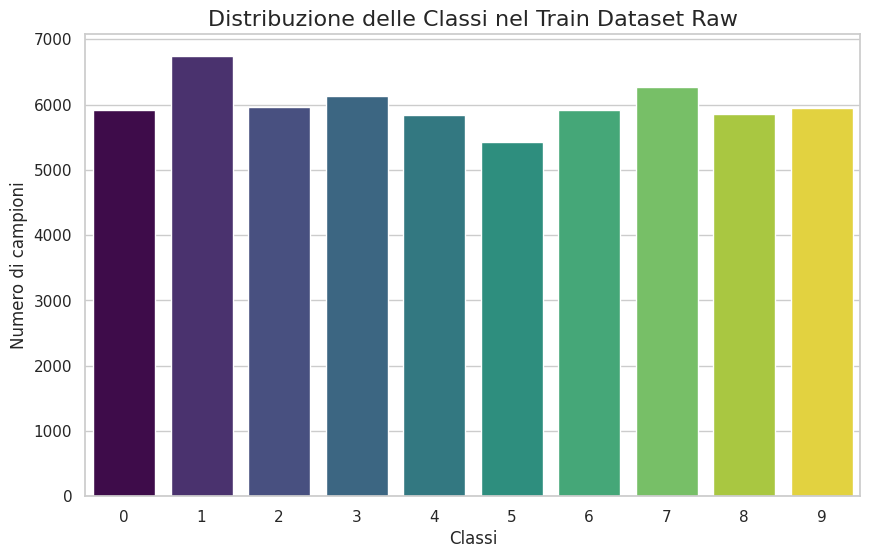

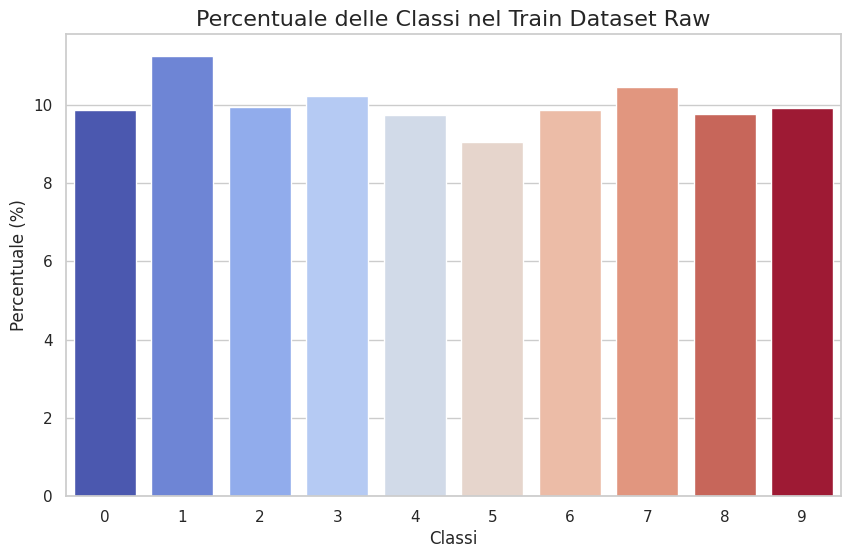

In [3]:
utils.plot_dataset_raw_statistics(train_dataset_raw, "Train Dataset Raw")

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


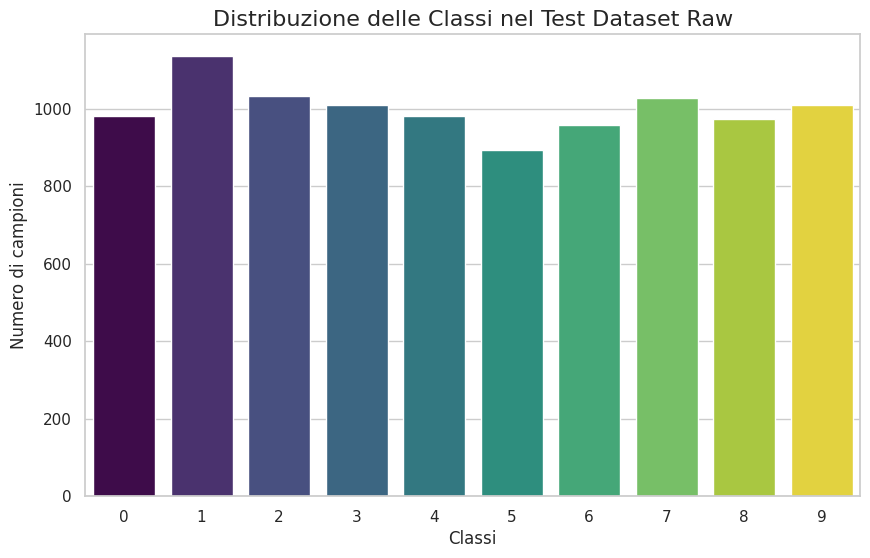

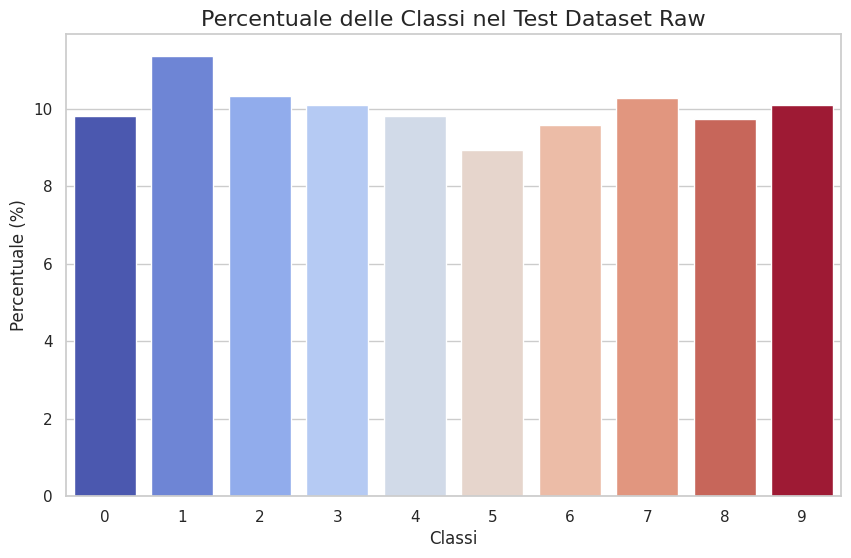

In [4]:
utils.plot_dataset_raw_statistics(test_dataset_raw, "Test Dataset Raw")

Numero totale di campioni: 60000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 20000, 1: 20000, 2: 20000}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 20000 campioni (33.33%)
Relazione 1: 20000 campioni (33.33%)
Relazione 2: 20000 campioni (33.33%)




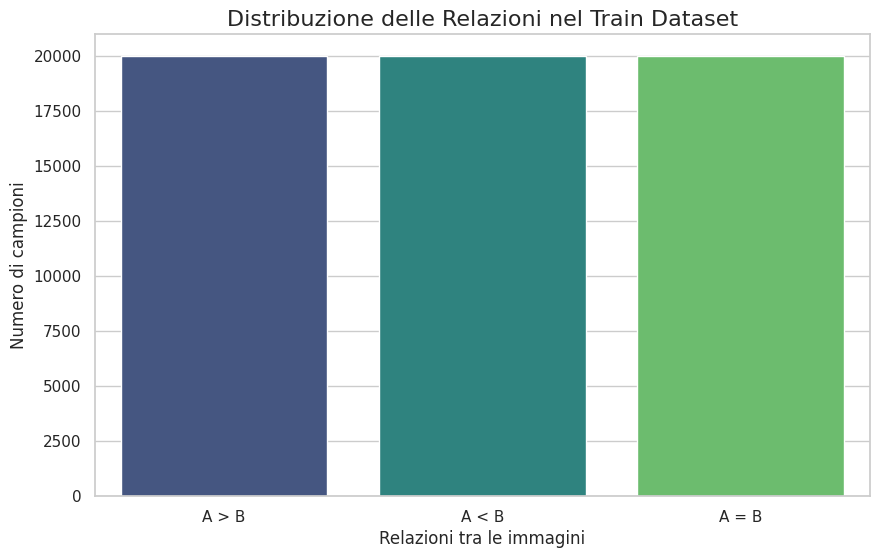

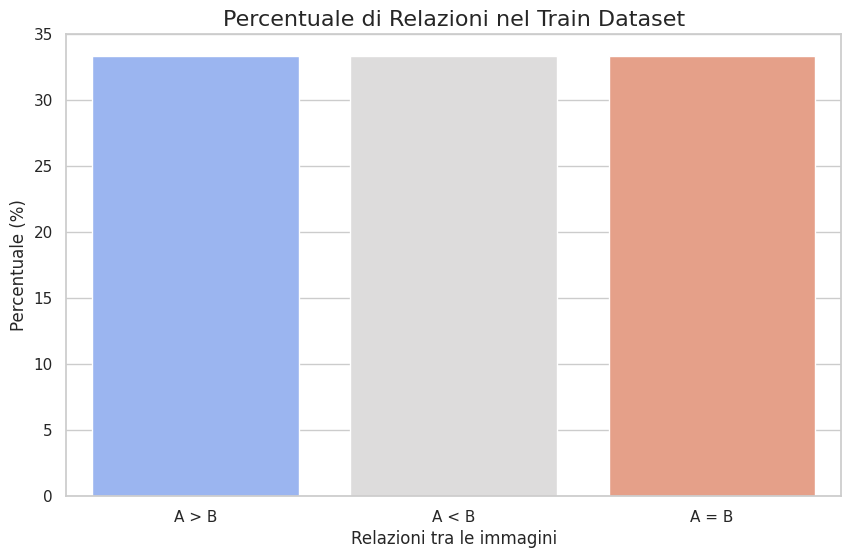

In [5]:
utils.plot_dataset_statistics(train_dataset, dataset_name="Train Dataset")

Numero totale di campioni: 3000
Distribuzione delle relazioni (A > B, A < B, A = B): {2: 979, 0: 986, 1: 1035}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 2: 979 campioni (32.63%)
Relazione 0: 986 campioni (32.87%)
Relazione 1: 1035 campioni (34.50%)




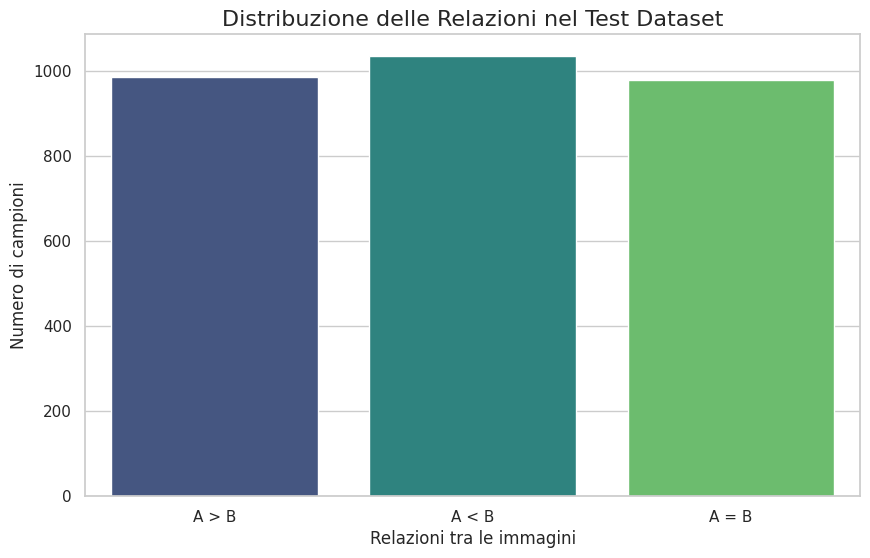

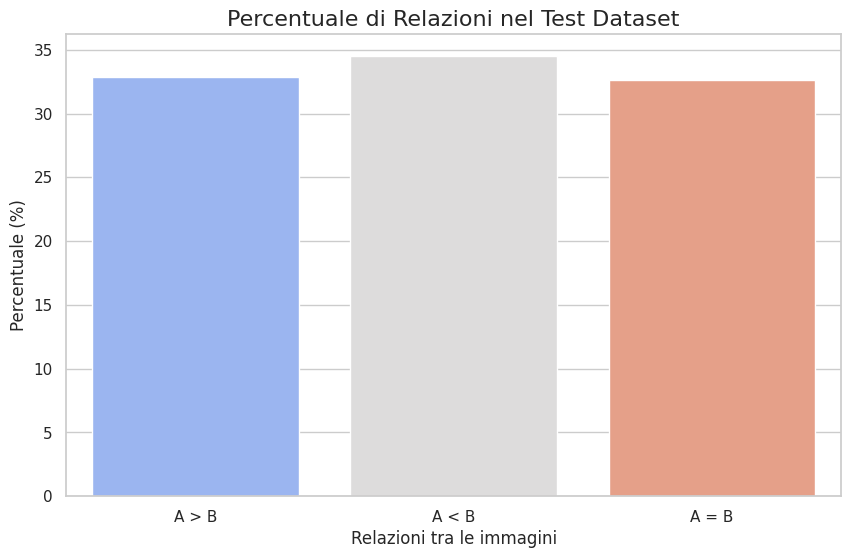

In [6]:
utils.plot_dataset_statistics(test_dataset, dataset_name="Test Dataset")

Numero totale di campioni: 6999
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 2347, 1: 2298, 2: 2354}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 2347 campioni (33.53%)
Relazione 1: 2298 campioni (32.83%)
Relazione 2: 2354 campioni (33.63%)




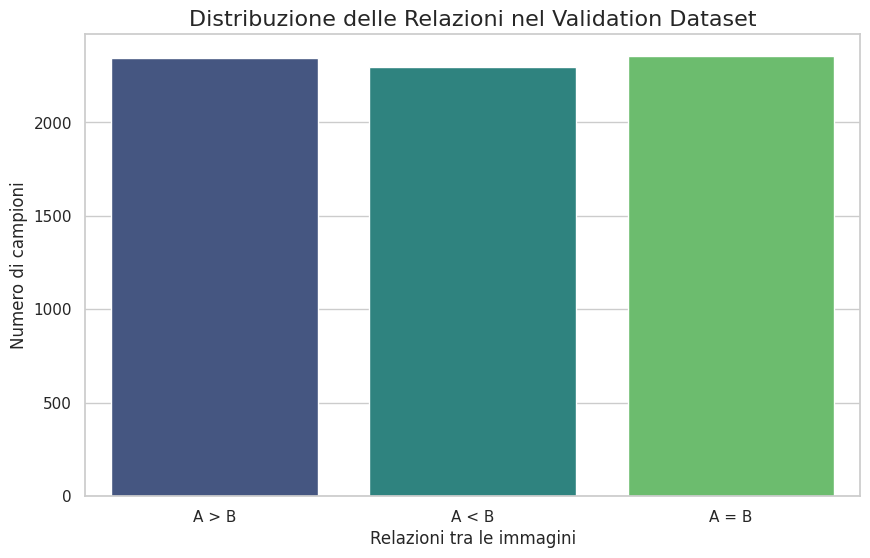

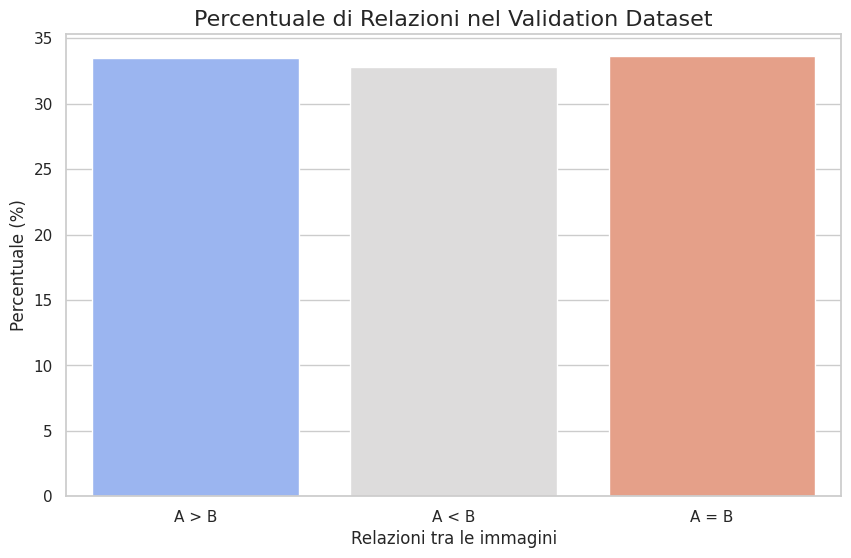

In [7]:
utils.plot_dataset_statistics(validation_dataset, dataset_name="Validation Dataset")

In [8]:
train_loader, validation_loader, test_loader = utils.create_data_loader(train_dataset, validation_dataset, test_dataset, BATCH_SIZE)

In [9]:
print("Size train_loader: ", len(train_loader), " Size train_dataset: ", len(train_dataset))
print("Size validation_loader: ", len(validation_loader), " Size validation_dataset: ", len(validation_dataset))
print("Size test_loader: ", len(test_loader), " Size test_dataset: ", len(test_dataset))

Size train_loader:  469  Size train_dataset:  60000
Size validation_loader:  55  Size validation_dataset:  6999
Size test_loader:  24  Size test_dataset:  3000


In [98]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [99]:
class DeeperLeNet5(nn.Module):
    def __init__(self):
        super(DeeperLeNet5, self).__init__()
        
        self.conv1 = nn.Conv2d(2, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(64 * 4 * 4, 240)
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv4(x))

        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = DeeperLeNet5()
print(model)


DeeperLeNet5(
  (conv1): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=240, bias=True)
  (fc2): Linear(in_features=240, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=3, bias=True)
)


In [100]:
criterion = nn.CrossEntropyLoss()
if OPTIMIZER == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
elif OPTIMIZER == 'ADAM':
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

if REDUCE_ON_PLATEAU:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
elif COSINE_ANNEALING:
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
elif STEPLR:
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7, verbose=True)

images dtype: torch.float32, labels dtype: torch.int64


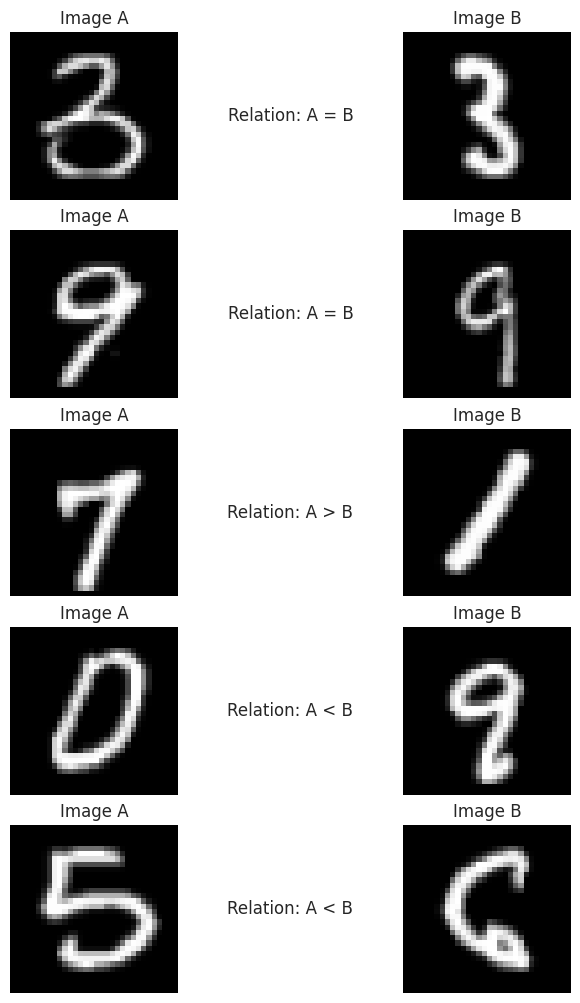

In [101]:

if OPTIMIZER == 'SGD':
    fileName = f"runs/log32x32deep_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_m={MOMENTUM}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"
elif OPTIMIZER == 'ADAM':
    fileName = f"runs/log32x32deep_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"

writer = SummaryWriter(fileName)

# Ottieni un batch dal dataloader
batch = next(iter(train_loader))
images, labels = batch

# Stampa il tipo di dato di ciascun tensore per debug
print(f"images dtype: {images.dtype}, labels dtype: {labels.dtype}")

#writer.add_graph(model, next(iter(train_loader))[0])

writer.add_figure('Image_pair', utils.show_dataset(train_loader, 5))

In [102]:
def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    train_loss_list = []
    train_accuracy_list = []
    
    # Inizializzazione della progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        train_loss_list.append(loss_value)
        train_accuracy_list.append(100 * correct_train / total_train)

        train_itr += 1
    
        # Aggiorna il valore della loss nella progress bar per ogni iterazione
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return running_loss / len(train_data_loader), 100 * correct_train / total_train, train_loss_list, train_accuracy_list

def validate(data_loader, model):
    print('Validating')
    val_itr = 0
    correct = 0
    total = 0
    running_loss = 0.0
    val_loss_list = []
    val_accuracy_list = []
    
    prog_bar = tqdm(data_loader, total=len(data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss_value = loss.item()
        running_loss += loss_value
        val_loss_list.append(loss_value)
        val_accuracy_list.append(100 * correct / total)
        val_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value, 100 * correct / total, val_loss_list, val_accuracy_list

In [103]:
# TRAIN!!!
start_epoch = 0
if RESUME_TRAINING and os.path.exists(checkpoint_path):
    start_epoch, best_val_loss, patience_counter = utils.load_checkpoint(model, optimizer, scheduler, checkpoint_path)

model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
total_val_loss = []
total_val_acc = []
total_train_loss = []
total_train_acc = []
lr_history = []
best_val_loss = float('inf')
for epoch in range(EPOCHS):
        print(f"\nEPOCH {epoch+1} of {EPOCHS}")

        start = time.time()
        train_loss, train_acc, train_loss_list, train_acc_list = train(train_loader, model)
        val_loss, val_acc, val_loss_list, val_acc_list = validate(validation_loader, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        total_train_loss.extend(train_loss_list)
        total_train_acc.extend(train_acc_list)
        total_val_loss.extend(val_loss_list)
        total_val_acc.extend(val_acc_list)

        if REDUCE_ON_PLATEAU:
                scheduler.step(val_loss)
        else:
                scheduler.step()

        lr_history.append(optimizer.param_groups[0]['lr'])

        print(f"Epoch #{epoch+1} train loss: {train_loss:.3f} train accuracy: {train_acc:.2f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f} validation accuracy: {val_acc:.2f}")   
        end = time.time()
        print("Learning rate actual: ", optimizer.param_groups[0]['lr'])
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")
        writer.add_scalars('Loss', {
                'Train': train_loss,
                'Validation': val_loss
        }, epoch + 1)
        
        writer.add_scalars('Accuracy', {
                'Train': train_acc,
                'Validation': val_acc
        }, epoch + 1)

        if EARLY_STOPPING:
                if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        best_model_state = model.state_dict()
                else:
                        patience_counter += 1
                        print(f"No improvement for {patience_counter} epoch(s).")
                if patience_counter >= ES_PATIENCE:
                        print(f"Early stopping triggered after {epoch+1} epochs.")
                        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)
                        break

        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)

if EARLY_STOPPING and 'best_model_state' in locals():
    model.load_state_dict(best_model_state)

# Valida il modello appena trainato con il test set
model.eval()
test_loss, test_acc, _, _ = validate(test_loader, model)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.2f}")
writer.add_scalar('Test Loss', test_loss)
writer.add_scalar('Test Accuracy', test_acc)



EPOCH 1 of 30
Training


Loss: 1.0998: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s]


Validating


Loss: 1.1005: 100%|██████████| 55/55 [00:00<00:00, 55.10it/s]


Epoch #1 train loss: 1.098 train accuracy: 34.30
Epoch #1 validation loss: 1.101 validation accuracy: 33.63
Learning rate actual:  0.009990133642141357
Took 0.352 minutes for epoch 1
Checkpoint saved at epoch 1.

EPOCH 2 of 30
Training


Loss: 0.8926: 100%|██████████| 469/469 [00:19<00:00, 23.63it/s]


Validating


Loss: 0.8459: 100%|██████████| 55/55 [00:01<00:00, 49.09it/s]


Epoch #2 train loss: 1.015 train accuracy: 47.61
Epoch #2 validation loss: 0.846 validation accuracy: 68.94
Learning rate actual:  0.009960573506572389
Took 0.350 minutes for epoch 2
Checkpoint saved at epoch 2.

EPOCH 3 of 30
Training


Loss: 0.4921: 100%|██████████| 469/469 [00:33<00:00, 14.01it/s]


Validating


Loss: 0.5366: 100%|██████████| 55/55 [00:01<00:00, 41.09it/s]


Epoch #3 train loss: 0.584 train accuracy: 76.02
Epoch #3 validation loss: 0.537 validation accuracy: 79.21
Learning rate actual:  0.009911436253643442
Took 0.580 minutes for epoch 3
Checkpoint saved at epoch 3.

EPOCH 4 of 30
Training


Loss: 0.4360: 100%|██████████| 469/469 [00:33<00:00, 13.80it/s]


Validating


Loss: 0.3971: 100%|██████████| 55/55 [00:01<00:00, 28.32it/s]


Epoch #4 train loss: 0.395 train accuracy: 84.59
Epoch #4 validation loss: 0.397 validation accuracy: 86.44
Learning rate actual:  0.009842915805643154
Took 0.599 minutes for epoch 4
Checkpoint saved at epoch 4.

EPOCH 5 of 30
Training


Loss: 0.2281: 100%|██████████| 469/469 [00:26<00:00, 17.52it/s]


Validating


Loss: 0.3344: 100%|██████████| 55/55 [00:01<00:00, 38.14it/s]


Epoch #5 train loss: 0.301 train accuracy: 88.52
Epoch #5 validation loss: 0.334 validation accuracy: 89.77
Learning rate actual:  0.009755282581475767
Took 0.470 minutes for epoch 5
Checkpoint saved at epoch 5.

EPOCH 6 of 30
Training


Loss: 0.2357: 100%|██████████| 469/469 [00:26<00:00, 18.01it/s]


Validating


Loss: 0.3714: 100%|██████████| 55/55 [00:01<00:00, 45.32it/s]


Epoch #6 train loss: 0.248 train accuracy: 90.77
Epoch #6 validation loss: 0.371 validation accuracy: 89.90
Learning rate actual:  0.009648882429441256
Took 0.455 minutes for epoch 6
No improvement for 1 epoch(s).
Checkpoint saved at epoch 6.

EPOCH 7 of 30
Training


Loss: 0.1270: 100%|██████████| 469/469 [00:22<00:00, 20.84it/s]


Validating


Loss: 0.3359: 100%|██████████| 55/55 [00:01<00:00, 40.84it/s]


Epoch #7 train loss: 0.200 train accuracy: 92.55
Epoch #7 validation loss: 0.336 validation accuracy: 91.04
Learning rate actual:  0.009524135262330098
Took 0.398 minutes for epoch 7
No improvement for 2 epoch(s).
Checkpoint saved at epoch 7.

EPOCH 8 of 30
Training


Loss: 0.1308: 100%|██████████| 469/469 [00:22<00:00, 20.96it/s]


Validating


Loss: 0.3635: 100%|██████████| 55/55 [00:01<00:00, 45.17it/s]


Epoch #8 train loss: 0.169 train accuracy: 93.80
Epoch #8 validation loss: 0.364 validation accuracy: 92.30
Learning rate actual:  0.009381533400219317
Took 0.393 minutes for epoch 8
No improvement for 3 epoch(s).
Early stopping triggered after 8 epochs.
Checkpoint saved at epoch 8.
Validating


Loss: 0.2198: 100%|██████████| 24/24 [00:00<00:00, 44.45it/s]

Test loss: 0.220 Test accuracy: 92.27


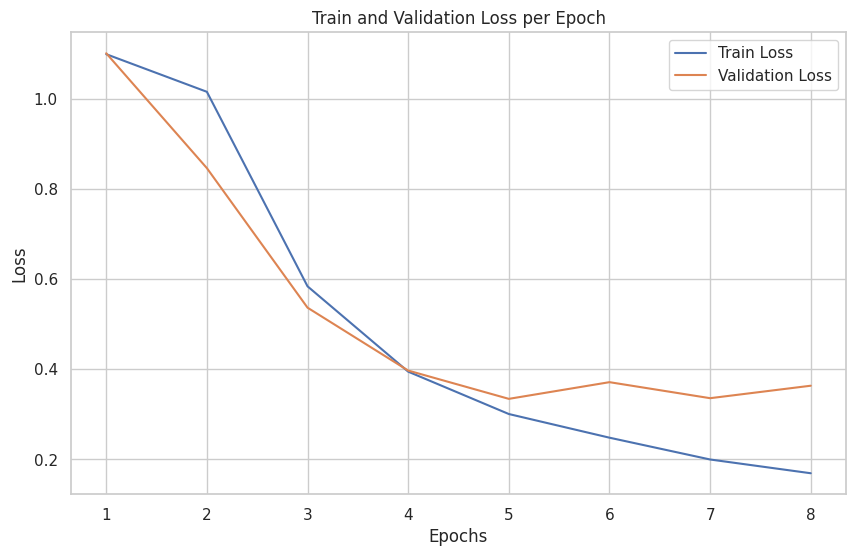

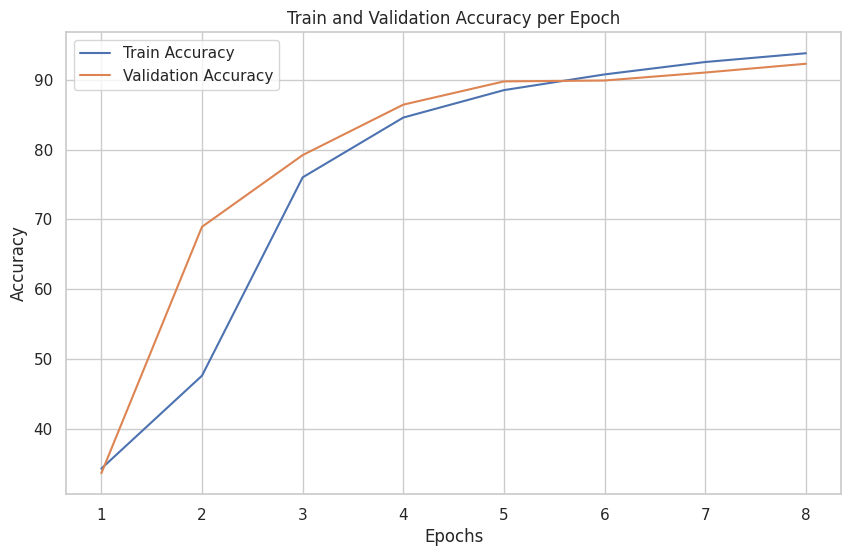

In [104]:
utils.plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                        total_train_loss, total_val_loss, total_train_acc, total_val_acc)

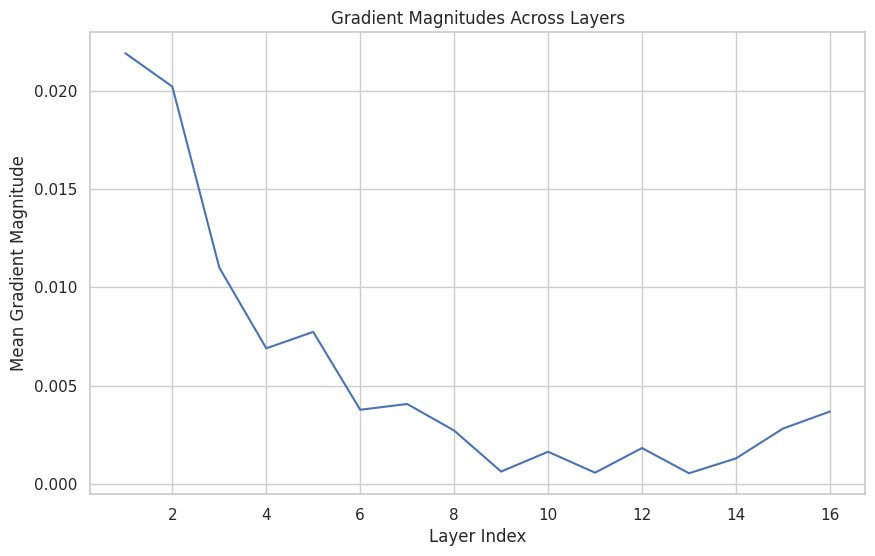

In [105]:
utils.plot_gradient(model)

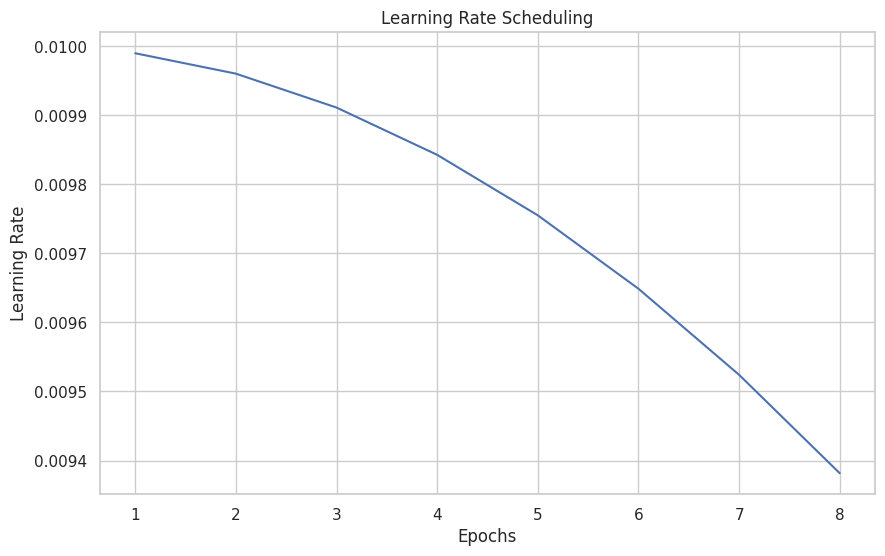

In [106]:
utils.plot_lr_scheduler(lr_history)

In [107]:
all_preds_val, all_labels_val, all_images_A_val, all_images_B_val = utils.inference(model, validation_loader, device)
all_preds_test, all_labels_test, all_images_A_test, all_images_B_test = utils.inference(model, test_loader, device)

539 previsioni errate trovate.


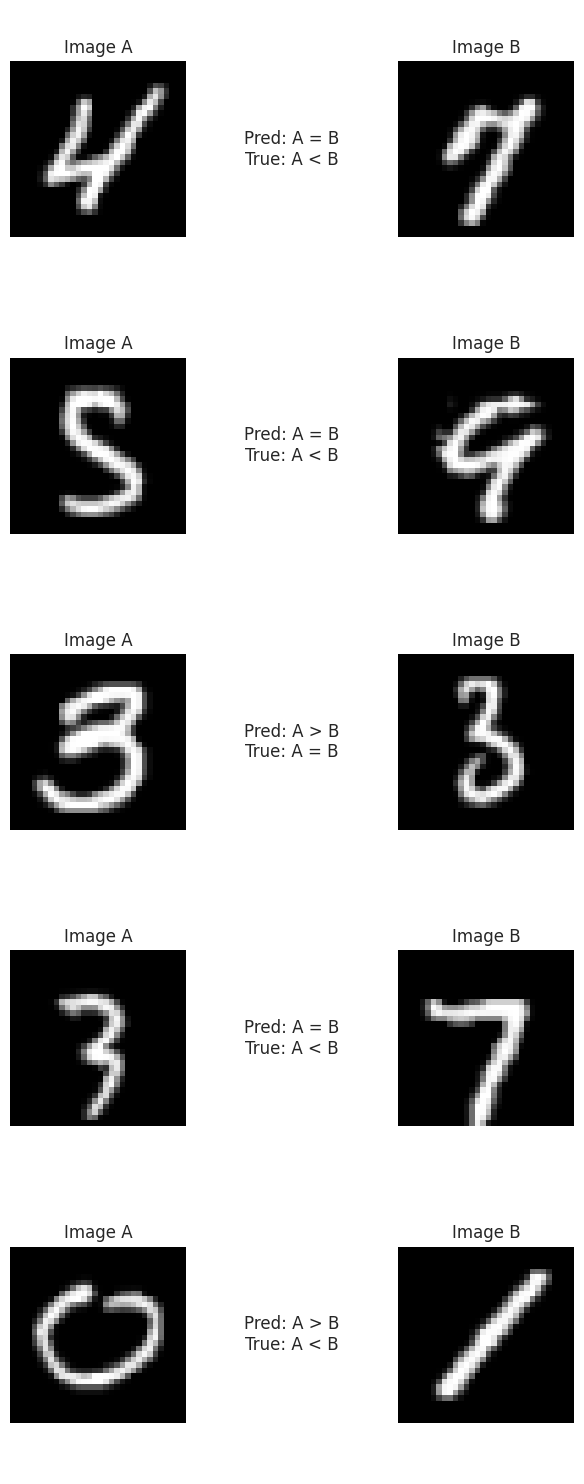

In [108]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions_validation', utils.show_incorrect_predictions(all_preds_val, all_labels_val, all_images_A_val, all_images_B_val, num_images=5))

In [ ]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions_test', utils.show_incorrect_predictions(all_preds_test, all_labels_test, all_images_A_test, all_images_B_test, num_images=5))

232 previsioni errate trovate.


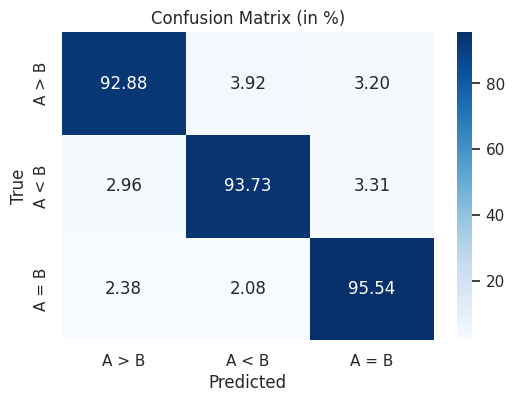

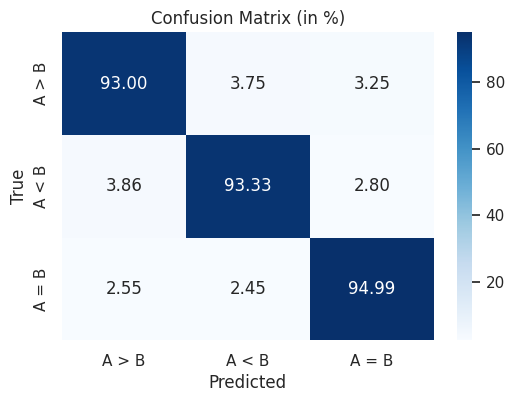

In [ ]:
# Calcola e visualizza la matrice di confusione
writer.add_figure('Confusion_matrix_validation', utils.plot_confusion_matrix(all_preds_val, all_labels_val))
writer.add_figure('Confusion_matrix_test', utils.plot_confusion_matrix(all_preds_test, all_labels_test))
#plot_confusion_matrix(model, test_loader, device)


In [ ]:
# Stampa il report delle metriche
utils.classification_metrics(all_preds_test, all_labels_test)

              precision    recall  f1-score   support

       A > B       0.93      0.93      0.93       986
       A < B       0.94      0.93      0.94      1035
       A = B       0.94      0.95      0.94       979

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



Precision: Il numero di veri positivi diviso per il numero di esempi che sono stati predetti come positivi.
Recall (Sensibilità): Il numero di veri positivi diviso per il numero di esempi che appartengono effettivamente alla classe positiva.
F1-Score: La media armonica tra precisione e recall. È utile quando hai un dataset squilibrato.
Support: Il numero di campioni effettivi per ogni classe.

In [ ]:
def save_notebook_copy(notebook_name='main.ipynb'):
    # Leggi il notebook attuale
    with open(notebook_name, 'r') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    # Costruisci il nome base del nuovo notebook
    if OPTIMIZER == 'SGD':
        base_name = f"run32x32deep_BS={BATCH_SIZE}_LR={LEARNING_RATE}_MOM={MOMENTUM}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}"
    elif OPTIMIZER == 'ADAM':
        base_name = f"run32x32deep_BS={BATCH_SIZE}_LR={LEARNING_RATE}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}"
    else:
        base_name = "run32x32deep"

    # Aggiungi estensione .ipynb
    new_notebook_name = f"{base_name}.ipynb"

    # Evita sovrascritture aggiungendo un numero incrementale se il file esiste
    counter = 1
    while os.path.exists(new_notebook_name):
        new_notebook_name = f"{base_name}_{counter}.ipynb"
        counter += 1

    # Salva il notebook con il nuovo nome
    with open(new_notebook_name, 'w') as f:
        nbformat.write(notebook_content, f)
    
    print(f"Notebook saved as {new_notebook_name}")


# Specifica il nome del notebook attuale
save_notebook_copy('main_32x32_deep.ipynb')


Notebook saved as run32x32deep_BS=128_LR=0.001_EPOCHS=30_AUG=False_TRA=False_OPT=ADAM.ipynb


In [ ]:
writer.close()